# Agent-Based Kinetics via Topology (ABa-KiTo)
Date: 09.11.2025

In this notebook I run clustering analysis with different size of intervals and seed to check the clustering of simulation when h is a linear function

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist
import pickle
import json
import pandas as pd
from datetime import datetime


import sys
import os
import torch as pt
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("NumPy version:", np.__version__)
print("Torch version:", pt.__version__)


NumPy version: 1.26.4
Torch version: 2.3.0+cpu


In [3]:
# Get the absolute path of the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..','..','..'))

# Add it to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import necessary functions
from src.modules_mokito import *

In [4]:
#Load data formatted from ABM simulations and ISOKANN.jl 

sims_path = os.path.join('ABa-KiTo', 'voter_dynamics_SW', 'data', 'simulations','')
data_dir =  os.path.join(project_root, sims_path)

# Read data
states_data = np.load(data_dir + '2025-11-18-data_VD_SW_3InteractingAgents.npz')
xs = states_data['xs'] #xs.shape (n_dim, n_samples)
ys = states_data['ys'] #ys-shape (n_dim, n_koop = 1, n_samples)

#Reshape data to use it for MoKiTo
X0 = xs.T #(n_samples, n_dim)
Xt = np.transpose(ys, (2, 1, 0))   # (n_samples, 1, n_dim)

# --- Log + Scale both X0 and Xt consistently ---
scaler = StandardScaler()

# X0
X0_log = np.log1p(X0)
X0_scaled = scaler.fit_transform(X0_log)   # (n_samples, n_dim)

# Xt: flatten for scaling
Xt_flat = Xt.reshape(-1, Xt.shape[2])      # (n_samples * n_koop, n_dim)
Xt_log = np.log1p(Xt_flat)
Xt_scaled = scaler.transform(Xt_log)
Xt_scaled = Xt_scaled.reshape(Xt.shape)    # (n_samples, 1, n_dim)


# # # --- Load chi function ---
chivals_path = os.path.join('ABa-KiTo', 'voter_dynamics_SW','data',  'chi_vals', '')
chivals_dir = os.path.join(project_root, chivals_path)
chi0 = np.load(chivals_dir + 'chi_values_VD_SW.npz')

# --- Organize for MoKiTo ---
data = OrganizeData(X0_scaled, Xt_scaled, chi0)





Check shape of input data
X0.shape   =  (200000, 202)
Xt.shape   =  (200000, 1, 202)
chi0.shape =  (200000,)
  


In [7]:
# Create results directory
# Create the path and ensure the directory exists for saving the data
clustering_dir = os.path.join("..", 'data', 'clustering_results')
os.makedirs(clustering_dir, exist_ok=True)

# Run stability analysis
stability_results = []
intervals =[3,4]
seeds = [42, 123, 456]

for i, Nintervals in enumerate(intervals):
    for seed in seeds:
        print(f"\n{'='*60}")
        print(f"Running: Nintervals={Nintervals}, seed={seed}")
        print(f"{'='*60}")
        
        # Run pipeline
        FCs = FindIntervals(data, Nintervals=Nintervals, 
                            clustering='kmeans', random_state=seed)
        FNs = FindNodes(data, FCs, algorithm='HDBSCAN', random_state=seed)
        
        # Calculate statistics
        chi_means = []
        cluster_sizes = []
        interval_assignments = []
        
        for node_id in range(FNs.Nnodes):
            mask = FNs.nodes == node_id
            chi_means.append(np.mean(data.chi0[mask]))
            cluster_sizes.append(np.sum(mask))
            interval_assignments.append(FNs.index_chi_node[node_id])
        
        chi_means = np.array(chi_means)
        cluster_sizes = np.array(cluster_sizes)
        interval_assignments = np.array(interval_assignments)
        
        # Classify into meta estable states (adjust thresholds based on your data)
        n_brown = np.sum(chi_means < 0.25)
        n_transition = np.sum((chi_means >= 0.25) & (chi_means < 0.55))
        n_green = np.sum(chi_means >= 0.55)
        
        # Store results
        result = {
            'Nintervals': Nintervals,
            'seed': seed,
            'n_clusters': FNs.Nnodes,
            'noise_count': np.sum(FNs.nodes == -1),
            'noise_pct': 100 * np.sum(FNs.nodes == -1) / data.N,
            'n_brown': n_brown,
            'n_transition': n_transition,
            'n_green': n_green,
            'chi_min': float(chi_means.min()),
            'chi_max': float(chi_means.max()),
            'chi_mean': float(chi_means.mean()),
            'chi_std': float(chi_means.std()),
            'clusters_per_interval': FNs.index_chi_node.tolist() if hasattr(FNs.index_chi_node, 'tolist') else list(np.bincount(FNs.index_chi_node)),
            'mean_cluster_size': float(cluster_sizes.mean()),
            'median_cluster_size': float(np.median(cluster_sizes)),
            'max_cluster_size': int(cluster_sizes.max()),
            'min_cluster_size': int(cluster_sizes.min()),
            # Detailed per-cluster info
            'chi_per_cluster': chi_means.tolist(),
            'size_per_cluster': cluster_sizes.tolist(),
            'interval_per_cluster': interval_assignments.tolist(),
        }
        
        stability_results.append(result)
        
        # Save individual run (in case of crashes)
        run_name = f"Nint{Nintervals}_seed{seed}"
        
        # Save as pickle (preserves all Python objects)
        with open(f'{clustering_dir}/{run_name}_FNs.pkl', 'wb') as f:
            pickle.dump(FNs, f)
        
        with open(f'{clustering_dir}/{run_name}_FCs.pkl', 'wb') as f:
            pickle.dump(FCs, f)
        
        print(f"\nSummary:")
        print(f"  Total clusters: {FNs.Nnodes}")
        print(f"  Noise: {result['noise_pct']:.1f}%")
        print(f"  Basins: Brown={n_brown}, Transition={n_transition}, Green={n_green}")
        print(f"  Chi range: [{result['chi_min']:.3f}, {result['chi_max']:.3f}]")

# Save all results as JSON (human-readable)
# with open('stability_results/all_results.json', 'w') as f:
#     json.dump(stability_results, f, indent=2)

# Save as DataFrame for easy analysis
df = pd.DataFrame(stability_results)
df.to_csv(f'{clustering_dir}/summary.csv', index=False)
print(f"\n{'='*60}")
print("All results saved to clustering_dir/")
print(f"{'='*60}")


Running: Nintervals=3, seed=42
Computing geometric interval densities...
unormalized density: [0.57874607 0.52615035 0.42883889]
Density estimates: min=0.815, median=1.000, max=1.100
d_low (25th percentile)=0.908, d_high (75th percentile)=1.050


Processing intervals:  33%|███▎      | 1/3 [41:40<1:23:21, 2500.99s/it]

Interval 0: size=114314, density=1.100, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 8477 noise (7.4%), reassigned=92.0%


Processing intervals:  67%|██████▋   | 2/3 [1:00:46<28:23, 1703.78s/it]

Interval 1: size=72495, density=1.000, min_cluster=54, min_samples=8, eps=1.05, method=eom → 2 clusters, 5707 noise (7.9%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 3/3 [1:02:00<00:00, 1240.14s/it]

Interval 2: size=13191, density=0.815, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 9 clusters, 834 noise (6.3%), reassigned=92.0%

Summary:
  Total clusters: 13
  Noise: 7.5%
  Basins: Brown=2, Transition=4, Green=7
  Chi range: [0.202, 0.697]

Running: Nintervals=3, seed=123


Computing geometric interval densities...
unormalized density: [0.58295485 0.52955648 0.42954685]
Density estimates: min=0.811, median=1.000, max=1.101
d_low (25th percentile)=0.906, d_high (75th percentile)=1.050


Processing intervals:  33%|███▎      | 1/3 [41:27<1:22:54, 2487.33s/it]

Interval 0: size=112868, density=1.101, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 8368 noise (7.4%), reassigned=92.0%


Processing intervals:  67%|██████▋   | 2/3 [1:00:36<28:20, 1700.32s/it]

Interval 1: size=73387, density=1.000, min_cluster=55, min_samples=8, eps=1.05, method=eom → 2 clusters, 5773 noise (7.9%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 3/3 [1:01:53<00:00, 1237.95s/it]

Interval 2: size=13745, density=0.811, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 9 clusters, 872 noise (6.3%), reassigned=92.0%

Summary:
  Total clusters: 13
  Noise: 7.5%
  Basins: Brown=2, Transition=5, Green=6
  Chi range: [0.201, 0.692]

Running: Nintervals=3, seed=456


Computing geometric interval densities...
unormalized density: [0.58312365 0.53238919 0.43792895]
Density estimates: min=0.823, median=1.000, max=1.095
d_low (25th percentile)=0.911, d_high (75th percentile)=1.048


Processing intervals:  33%|███▎      | 1/3 [42:01<1:24:03, 2521.81s/it]

Interval 0: size=112904, density=1.095, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 8371 noise (7.4%), reassigned=92.0%


Processing intervals:  67%|██████▋   | 2/3 [59:28<27:34, 1654.00s/it]  

Interval 1: size=73362, density=1.000, min_cluster=55, min_samples=8, eps=1.05, method=eom → 2 clusters, 5771 noise (7.9%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 3/3 [1:00:44<00:00, 1214.79s/it]

Interval 2: size=13734, density=0.823, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 9 clusters, 871 noise (6.3%), reassigned=92.0%

Summary:
  Total clusters: 13
  Noise: 7.5%
  Basins: Brown=2, Transition=5, Green=6
  Chi range: [0.201, 0.692]

Running: Nintervals=4, seed=42


Computing geometric interval densities...
unormalized density: [0.58500675 0.52728999 0.49299814 0.39146445]
Density estimates: min=0.767, median=1.000, max=1.147
d_low (25th percentile)=0.917, d_high (75th percentile)=1.062


Processing intervals:  25%|██▌       | 1/4 [23:10<1:09:30, 1390.07s/it]

Interval 0: size=82752, density=1.147, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 6089 noise (7.4%), reassigned=92.0%


Processing intervals:  50%|█████     | 2/4 [42:44<42:06, 1263.34s/it]  

Interval 1: size=77243, density=1.034, min_cluster=54, min_samples=8, eps=1.02, method=eom → 2 clusters, 5884 noise (7.6%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=46. Retrying with relaxed parameters...


Processing intervals:  75%|███████▌  | 3/4 [50:22<14:55, 895.67s/it] 

Interval 2: size=33947, density=0.966, min_cluster=36, min_samples=5, eps=1.30, method=eom (fallback) → 18 clusters, 1651 noise (4.9%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 4/4 [50:37<00:00, 759.37s/it]

Interval 3: size=6058, density=0.767, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 3 clusters, 464 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 25
  Noise: 7.0%
  Basins: Brown=2, Transition=20, Green=3
  Chi range: [0.181, 0.746]

Running: Nintervals=4, seed=123


Computing geometric interval densities...
unormalized density: [0.58863824 0.53180563 0.48621547 0.39137625]
Density estimates: min=0.769, median=1.000, max=1.156
d_low (25th percentile)=0.909, d_high (75th percentile)=1.073


Processing intervals:  25%|██▌       | 1/4 [23:52<1:11:37, 1432.64s/it]

Interval 0: size=86098, density=1.156, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 6340 noise (7.4%), reassigned=92.0%


Processing intervals:  50%|█████     | 2/4 [43:40<42:57, 1288.56s/it]  

Interval 1: size=76094, density=1.045, min_cluster=53, min_samples=8, eps=1.00, method=eom → 2 clusters, 5901 noise (7.8%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals:  75%|███████▌  | 3/4 [50:26<14:45, 885.77s/it] 

Interval 2: size=31997, density=0.955, min_cluster=37, min_samples=5, eps=1.32, method=eom (fallback) → 10 clusters, 1593 noise (5.0%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 4/4 [50:40<00:00, 760.15s/it]

Interval 3: size=5811, density=0.769, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 3 clusters, 444 noise (7.6%), reassigned=92.0%

Summary:
  Total clusters: 17
  Noise: 7.1%
  Basins: Brown=2, Transition=12, Green=3
  Chi range: [0.184, 0.752]

Running: Nintervals=4, seed=456


Computing geometric interval densities...
unormalized density: [0.58223597 0.53134671 0.49327651 0.39176131]
Density estimates: min=0.765, median=1.000, max=1.136
d_low (25th percentile)=0.913, d_high (75th percentile)=1.062


Processing intervals:  25%|██▌       | 1/4 [22:32<1:07:38, 1352.72s/it]

Interval 0: size=82272, density=1.136, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 6053 noise (7.4%), reassigned=92.0%


Processing intervals:  50%|█████     | 2/4 [42:55<42:32, 1276.32s/it]  

Interval 1: size=77480, density=1.037, min_cluster=54, min_samples=8, eps=1.01, method=eom → 2 clusters, 5901 noise (7.6%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=46. Retrying with relaxed parameters...


Processing intervals:  75%|███████▌  | 3/4 [50:38<15:04, 904.73s/it] 

Interval 2: size=34165, density=0.963, min_cluster=36, min_samples=5, eps=1.31, method=eom (fallback) → 19 clusters, 1650 noise (4.8%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 4/4 [50:52<00:00, 763.22s/it]

Interval 3: size=6083, density=0.765, min_cluster=37, min_samples=5, eps=1.32, method=leaf (fallback) → 3 clusters, 466 noise (7.7%), reassigned=92.0%

Summary:
  Total clusters: 26
  Noise: 7.0%
  Basins: Brown=2, Transition=21, Green=3
  Chi range: [0.181, 0.746]

All results saved to clustering_dir/


In [5]:
# Given that the clustering results are too fragmented, the number of initial intervals would be decrease to 2

# Create results directory
# Create the path and ensure the directory exists for saving the data
clustering_dir = os.path.join("..", 'data', 'clustering_results')
os.makedirs(clustering_dir, exist_ok=True)

# Load existing results if they exist
existing_results_file = f'{clustering_dir}/summary.csv'
if os.path.exists(existing_results_file):
    print(f"Loading existing results from {existing_results_file}")
    df_existing = pd.read_csv(existing_results_file)
    
    # Convert back to list of dictionaries
    stability_results = df_existing.to_dict('records')
    
    # Reconstruct lists from string representation if needed
    for result in stability_results:
        for key in ['clusters_per_interval', 'chi_per_cluster', 'size_per_cluster', 'interval_per_cluster']:
            if key in result and isinstance(result[key], str):
                result[key] = eval(result[key])  # Convert string back to list
    
    print(f"Loaded {len(stability_results)} existing results")
    
    # Check which configurations already exist
    existing_configs = set((r['Nintervals'], r['seed']) for r in stability_results)
    print(f"Existing configurations: {existing_configs}")
else:
    print("No existing results found, starting fresh")
    stability_results = []
    existing_configs = set()

# Run stability analysis
intervals = [2]  # Only run for intervals=2
seeds = [42, 123, 456]

for i, Nintervals in enumerate(intervals):
    for seed in seeds:
        # Skip if this configuration already exists
        if (Nintervals, seed) in existing_configs:
            print(f"\n{'='*60}")
            print(f"SKIPPING: Nintervals={Nintervals}, seed={seed} (already exists)")
            print(f"{'='*60}")
            continue
        
        print(f"\n{'='*60}")
        print(f"Running: Nintervals={Nintervals}, seed={seed}")
        print(f"{'='*60}")
        
        # Run pipeline
        FCs = FindIntervals(data, Nintervals=Nintervals, 
                            clustering='kmeans', random_state=seed)
        FNs = FindNodes(data, FCs, algorithm='HDBSCAN', random_state=seed)
        
        # Calculate statistics
        chi_means = []
        cluster_sizes = []
        interval_assignments = []
        
        for node_id in range(FNs.Nnodes):
            mask = FNs.nodes == node_id
            chi_means.append(np.mean(data.chi0[mask]))
            cluster_sizes.append(np.sum(mask))
            interval_assignments.append(FNs.index_chi_node[node_id])
        
        chi_means = np.array(chi_means)
        cluster_sizes = np.array(cluster_sizes)
        interval_assignments = np.array(interval_assignments)
        
        # Classify into meta estable states (adjust thresholds based on your data)
        n_brown = np.sum(chi_means < 0.25)
        n_transition = np.sum((chi_means >= 0.25) & (chi_means < 0.55))
        n_green = np.sum(chi_means >= 0.55)
        
        # Store results
        result = {
            'Nintervals': Nintervals,
            'seed': seed,
            'n_clusters': FNs.Nnodes,
            'noise_count': np.sum(FNs.nodes == -1),
            'noise_pct': 100 * np.sum(FNs.nodes == -1) / data.N,
            'n_brown': n_brown,
            'n_transition': n_transition,
            'n_green': n_green,
            'chi_min': float(chi_means.min()),
            'chi_max': float(chi_means.max()),
            'chi_mean': float(chi_means.mean()),
            'chi_std': float(chi_means.std()),
            'clusters_per_interval': FNs.index_chi_node.tolist() if hasattr(FNs.index_chi_node, 'tolist') else list(np.bincount(FNs.index_chi_node)),
            'mean_cluster_size': float(cluster_sizes.mean()),
            'median_cluster_size': float(np.median(cluster_sizes)),
            'max_cluster_size': int(cluster_sizes.max()),
            'min_cluster_size': int(cluster_sizes.min()),
            # Detailed per-cluster info
            'chi_per_cluster': chi_means.tolist(),
            'size_per_cluster': cluster_sizes.tolist(),
            'interval_per_cluster': interval_assignments.tolist(),
        }
        
        stability_results.append(result)
        
        # Save individual run (in case of crashes)
        run_name = f"Nint{Nintervals}_seed{seed}"
        
        # Save as pickle (preserves all Python objects)
        with open(f'{clustering_dir}/{run_name}_FNs.pkl', 'wb') as f:
            pickle.dump(FNs, f)
        
        with open(f'{clustering_dir}/{run_name}_FCs.pkl', 'wb') as f:
            pickle.dump(FCs, f)
        
        print(f"\nSummary:")
        print(f"  Total clusters: {FNs.Nnodes}")
        print(f"  Noise: {result['noise_pct']:.1f}%")
        print(f"  Basins: Brown={n_brown}, Transition={n_transition}, Green={n_green}")
        print(f"  Chi range: [{result['chi_min']:.3f}, {result['chi_max']:.3f}]")

# Save all results (existing + new)
df = pd.DataFrame(stability_results)
df.to_csv(f'{clustering_dir}/summary.csv', index=False)

print(f"\n{'='*60}")
print(f"Total results: {len(stability_results)}")
print("All results saved to clustering_dir/")
print(f"{'='*60}")

# Optional: Show summary by Nintervals
print("\nResults by Nintervals:")
print(df.groupby('Nintervals').size())

Loading existing results from ..\data\clustering_results/summary.csv
Loaded 6 existing results
Existing configurations: {(4, 42), (3, 123), (3, 42), (4, 456), (3, 456), (4, 123)}

Running: Nintervals=2, seed=42
Computing geometric interval densities...
unormalized density: [0.58011868 0.48606242]
Density estimates: min=0.912, median=1.000, max=1.088
d_low (25th percentile)=0.956, d_high (75th percentile)=1.044


Processing intervals:  50%|█████     | 1/2 [1:09:30<1:09:30, 4170.66s/it]

Interval 0: size=153033, density=1.088, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 11453 noise (7.5%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 2/2 [1:21:13<00:00, 2436.82s/it]  

Interval 1: size=46967, density=0.912, min_cluster=37, min_samples=5, eps=1.32, method=eom (fallback) → 19 clusters, 2412 noise (5.1%), reassigned=92.0%

Summary:
  Total clusters: 21
  Noise: 6.9%
  Basins: Brown=2, Transition=16, Green=3
  Chi range: [0.225, 0.618]

Running: Nintervals=2, seed=123


Computing geometric interval densities...
unormalized density: [0.57019748 0.48627665]
Density estimates: min=0.921, median=1.000, max=1.079
d_low (25th percentile)=0.960, d_high (75th percentile)=1.040


Processing intervals:  50%|█████     | 1/2 [1:10:21<1:10:21, 4221.95s/it]

Interval 0: size=153416, density=1.079, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 11484 noise (7.5%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 2/2 [1:22:02<00:00, 2461.46s/it]  

Interval 1: size=46584, density=0.921, min_cluster=37, min_samples=5, eps=1.32, method=eom (fallback) → 19 clusters, 2396 noise (5.1%), reassigned=92.0%

Summary:
  Total clusters: 21
  Noise: 6.9%
  Basins: Brown=2, Transition=16, Green=3
  Chi range: [0.225, 0.620]

Running: Nintervals=2, seed=456


Computing geometric interval densities...
unormalized density: [0.56729668 0.48512731]
Density estimates: min=0.922, median=1.000, max=1.078
d_low (25th percentile)=0.961, d_high (75th percentile)=1.039


Processing intervals:  50%|█████     | 1/2 [1:09:33<1:09:33, 4173.30s/it]

Interval 0: size=153355, density=1.078, min_cluster=54, min_samples=8, eps=1.00, method=eom → 2 clusters, 11479 noise (7.5%), reassigned=92.0%
  ⚠ No clusters found with min_cluster=47. Retrying with relaxed parameters...


Processing intervals: 100%|██████████| 2/2 [1:21:02<00:00, 2431.15s/it]  

Interval 1: size=46645, density=0.922, min_cluster=37, min_samples=5, eps=1.32, method=eom (fallback) → 19 clusters, 2401 noise (5.1%), reassigned=92.0%

Summary:
  Total clusters: 21
  Noise: 6.9%
  Basins: Brown=2, Transition=16, Green=3
  Chi range: [0.225, 0.620]

Total results: 9
All results saved to clustering_dir/

Results by Nintervals:
Nintervals
2    3
3    3
4    3
dtype: int64



=== STABILITY ANALYSIS SUMMARY ===

Overall Statistics:
  Total runs: 9
  Clusters per run: 18.9 ± 5.1
  Noise percentage: 7.2% ± 0.3%

Basin Structure (average across runs):
  Brown clusters: 2.0 ± 0.0
  Transition clusters: 12.8 ± 6.6
  Green clusters: 4.1 ± 1.7

Chi Value Ranges:
  Min chi: 0.203 ± 0.019
  Max chi: 0.687 ± 0.056


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (1).

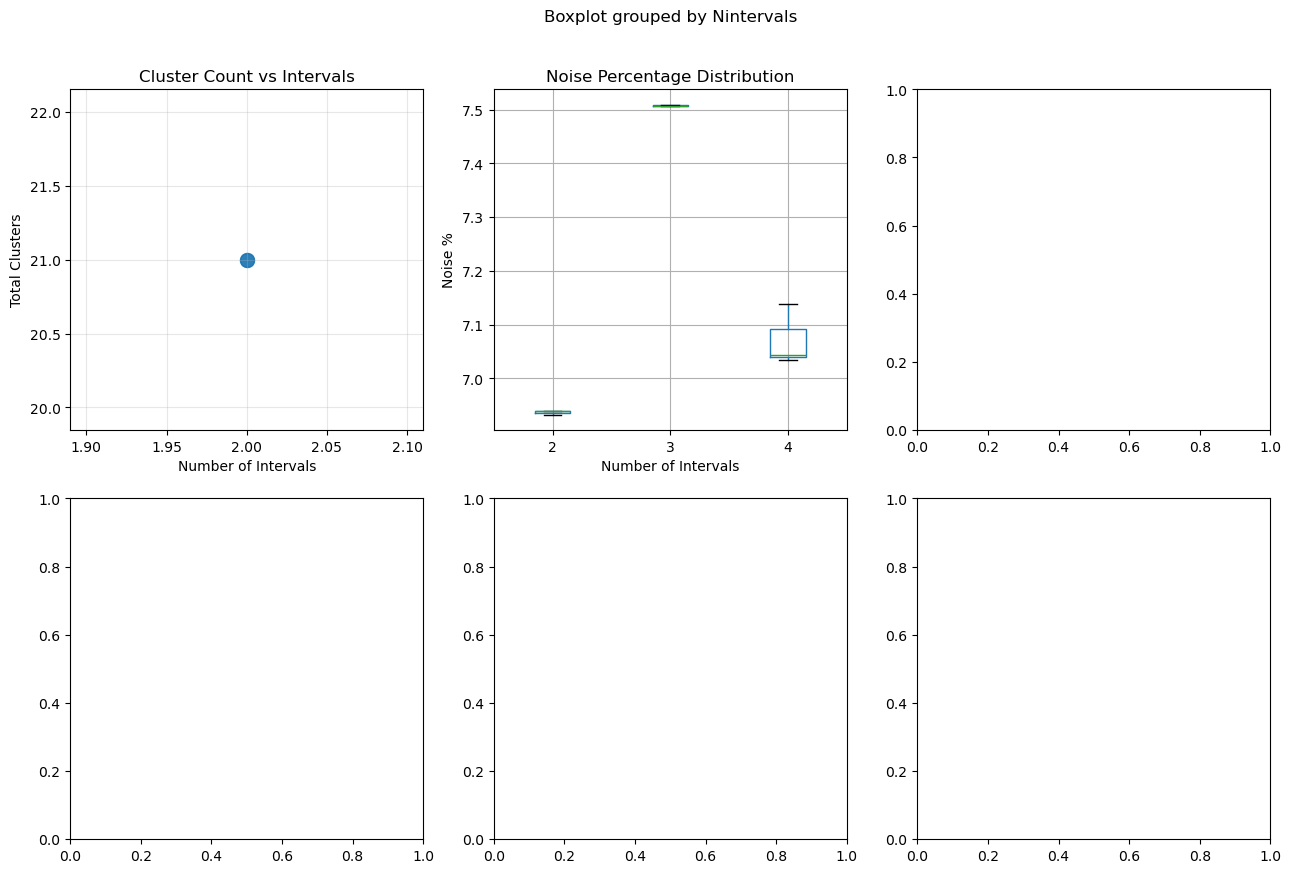

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
df = pd.read_csv(f'{clustering_dir}/summary.csv')

# Create summary statistics
print("\n=== STABILITY ANALYSIS SUMMARY ===\n")
print("Overall Statistics:")
print(f"  Total runs: {len(df)}")
print(f"  Clusters per run: {df['n_clusters'].mean():.1f} ± {df['n_clusters'].std():.1f}")
print(f"  Noise percentage: {df['noise_pct'].mean():.1f}% ± {df['noise_pct'].std():.1f}%")
print(f"\nBasin Structure (average across runs):")
print(f"  Brown clusters: {df['n_brown'].mean():.1f} ± {df['n_brown'].std():.1f}")
print(f"  Transition clusters: {df['n_transition'].mean():.1f} ± {df['n_transition'].std():.1f}")
print(f"  Green clusters: {df['n_green'].mean():.1f} ± {df['n_green'].std():.1f}")
print(f"\nChi Value Ranges:")
print(f"  Min chi: {df['chi_min'].mean():.3f} ± {df['chi_min'].std():.3f}")
print(f"  Max chi: {df['chi_max'].mean():.3f} ± {df['chi_max'].std():.3f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Number of clusters vs parameters
ax = axes[0, 0]
for Nint in intervals:
    subset = df[df['Nintervals'] == Nint]
    ax.scatter([Nint]*len(subset), subset['n_clusters'], 
               s=100, alpha=0.6, label=f'N={Nint}')
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Total Clusters')
ax.set_title('Cluster Count vs Intervals')
ax.grid(True, alpha=0.3)

# 2. Noise percentage
ax = axes[0, 1]
df.boxplot(column='noise_pct', by='Nintervals', ax=ax)
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Noise %')
ax.set_title('Noise Percentage Distribution')
plt.sca(ax)
plt.xticks([1, 2,3], intervals)

# 3. Basin composition
ax = axes[0, 2]
basin_means = df.groupby('Nintervals')[['n_brown', 'n_transition', 'n_green']].mean()
basin_means.plot(kind='bar', stacked=True, ax=ax, 
                 color=['#8B4513', '#FFD700', '#228B22'])
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Number of Clusters')
ax.set_title('Basin Composition')
ax.legend(['Brown', 'Transition', 'Green'])
ax.set_xticklabels([3,4], rotation=0)

# 4. Chi range stability
ax = axes[1, 0]
for idx, row in df.iterrows():
    ax.plot([row['Nintervals']]*2, [row['chi_min'], row['chi_max']], 
            'o-', alpha=0.5, markersize=8)
ax.set_xlabel('Number of Intervals')
ax.set_ylabel('Chi Value Range')
ax.set_title('Chi Value Ranges Across Runs')
ax.grid(True, alpha=0.3)

# 5. Cluster size distribution
ax = axes[1, 1]
df.boxplot(column=['min_cluster_size', 'median_cluster_size', 'max_cluster_size'], 
           ax=ax)
ax.set_ylabel('Cluster Size (log scale)')
ax.set_yscale('log')
ax.set_title('Cluster Size Statistics')
ax.set_xticklabels(['Min', 'Median', 'Max'], rotation=0)

# 6. Reproducibility heatmap
ax = axes[1, 2]
pivot = df.pivot_table(values='n_clusters', 
                       index='Nintervals', 
                       columns='seed', 
                       aggfunc='first')
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax)
ax.set_title('Cluster Count: Intervals × Seeds')
ax.set_xlabel('Random Seed')
ax.set_ylabel('Number of Intervals')

plt.tight_layout()
#plt.savefig('stability_results01/stability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure saved to stability_results01/stability_analysis.png")

In [9]:
# Simple stability checks
print("\n=== STABILITY CHECKS ===\n")

# Check 1: Does 3-basin structure always appear?
all_have_basins = all((df['n_brown'] > 0) & 
                      (df['n_transition'] > 0) & 
                      (df['n_green'] > 0))
print(f"✓ All runs show 3-basin structure: {all_have_basins}")

# Check 2: Are chi ranges consistent?
chi_range_cv = df['chi_min'].std() / df['chi_min'].mean()
print(f"✓ Chi minimum coefficient of variation: {chi_range_cv:.2%}")
print(f"  (< 10% = very stable, < 20% = stable, > 20% = variable)")

# Check 3: Is noise percentage reasonable?
noise_stable = df['noise_pct'].std() < 5.0  # Less than 5% variation
print(f"✓ Noise percentage stable (σ < 5%): {noise_stable}")
print(f"  Mean: {df['noise_pct'].mean():.1f}%, Std: {df['noise_pct'].std():.1f}%")

# Check 4: Does structure scale predictably with Nintervals?
corr = df[['Nintervals', 'n_clusters']].corr().iloc[0, 1]
print(f"✓ Clusters scale with intervals (correlation): {corr:.2f}")
print(f"  (> 0.8 = predictable scaling)")





=== STABILITY CHECKS ===

✓ All runs show 3-basin structure: True
✓ Chi minimum coefficient of variation: 5.60%
  (< 10% = very stable, < 20% = stable, > 20% = variable)
✓ Noise percentage stable (σ < 5%): True
  Mean: 7.3%, Std: 0.2%
✓ Clusters scale with intervals (correlation): 0.86
  (> 0.8 = predictable scaling)


In [10]:
import pandas as pd
import json

# Load results
df = pd.read_csv(f'{clustering_dir}/summary.csv')

print("\n=== DETAILED DIAGNOSTICS ===\n")

# Find runs missing basins
print("Runs missing basins:")
for idx, row in df.iterrows():
    missing = []
    if row['n_brown'] == 0:
        missing.append('BROWN')
    if row['n_transition'] == 0:
        missing.append('TRANSITION')
    if row['n_green'] == 0:
        missing.append('GREEN')
    
    if missing:
        print(f"  Nint={row['Nintervals']}, seed={row['seed']}: Missing {', '.join(missing)}")
        print(f"    → {row['n_clusters']} clusters, {row['noise_pct']:.1f}% noise")
        print(f"    → Chi range: [{row['chi_min']:.3f}, {row['chi_max']:.3f}]")

# Find high-noise runs
print("\nHigh noise runs (>15%):")
high_noise = df[df['noise_pct'] > 15]
for idx, row in high_noise.iterrows():
    print(f"  Nint={row['Nintervals']}, seed={row['seed']}: {row['noise_pct']:.1f}% noise")
    print(f"    → Basins: B={row['n_brown']}, T={row['n_transition']}, G={row['n_green']}")

# Show variation by Nintervals
print("\nStatistics by Nintervals:")
print(df.groupby('Nintervals')[['n_clusters', 'noise_pct', 'n_brown', 'n_transition', 'n_green']].agg(['mean', 'std']))


=== DETAILED DIAGNOSTICS ===

Runs missing basins:

High noise runs (>15%):

Statistics by Nintervals:
           n_clusters           noise_pct           n_brown      n_transition  \
                 mean       std      mean       std    mean  std         mean   
Nintervals                                                                      
3           13.000000  0.000000  7.507333  0.001443     2.0  0.0     4.666667   
4           22.666667  4.932883  7.072667  0.057622     2.0  0.0    17.666667   

                       n_green           
                 std      mean      std  
Nintervals                               
3           0.577350  6.333333  0.57735  
4           4.932883  3.000000  0.00000  
